# K-bandits

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
n_machines = 10
n_tokens = 1000
n_runs = 2000

In [ ]:
def argmax(a):
    return max(range(len(a)), key=lambda x: a[x])

In [ ]:
class Agent():
    
    def __init__(self, n_machines=10, algorithm="greedy_epsilon", epsilon=0, alpha=None, c_ucb=2, init=None):
        
        
        self.n_machines = n_machines # Total number of machines
        self.t = 1 # Step count
        self.N = np.zeros(n_machines) # Step count for each machine
        self.alpha = alpha # Learning rate
        self.algorithm = algorithm
        self.actions = np.arange(n_machines)
        
        self.mean_reward = 0
        #self.reward = np.zeros()
        
        # For epsilon greedy policy
        self.epsilon = epsilon
        
        # For UCB criterion
        self.c = c_ucb
        
        # For gradient bandit
        self.H = np.zeros(n_machines)
        
        # Initialisation of the Q-value function
        if init: # Optimistic initialisation
            self.Q = init * np.ones(n_machines)
        else:
            self.Q = np.random.normal(loc=0., scale=1., size=n_machines)
    
    def softmax(self):
        self.prob_action = np.exp(self.H - np.max(self.H)) / np.sum(np.exp(self.H - np.max(self.H)), axis=0)
        
    def learn(self, action, reward):
        self.t += 1
        self.N[action] += 1
        if self.alpha:
            if self.algorithm == "gradient":
                self.mean_reward = self.mean_reward + (reward - self.mean_reward) / self.t
                self.H[action] = self.H[action] + self.alpha * (reward - self.mean_reward) * (1 -
                self.prob_action[action])
                actions_not_taken = self.actions != action
                self.H[actions_not_taken] = self.H[actions_not_taken] - self.alpha * (reward - self.mean_reward) * self.prob_action[actions_not_taken]
            else:
                self.Q[action] = self.Q[action] + self.alpha * (reward - self.Q[action])
        else:
            self.Q[action] = self.Q[action] + (reward - self.Q[action]) / self.N[action]
    
    def act(self, algorithm):
        
         # Select action according to epsilon greedy policy
        if self.algorithm == "epsilon_greedy":
            prob = np.random.random()
            if prob <= self.epsilon:
                action = np.random.choice(n_machines)
            else:
                action = argmax(self.Q)
        
        # Select action according to UCB criteria
        if self.algorithm == "ucb":
            action = argmax(self.Q + self.c * np.sqrt(np.log(self.t) / self.N))
        
        # Gradient
        if self.algorithm == "gradient":
            # Update probabilities
            self.softmax()
            # Select highest preference action
            action = np.random.choice(self.actions, p=self.prob_action)
            
        return action

In [ ]:
def simulation(n_machines, n_tokens, n_runs, algorithm, epsilon=None, init=None, alpha=None):
    
    rewards = np.zeros(n_tokens)
    cpt_actions = np.zeros(n_tokens)
    
    # For every run...
    for i_run in tqdm(range(n_runs)):
        
        # Initialize q_star 
        q_star = np.random.normal(loc=0., scale=1., size=n_machines) # q* is constant
        optimal_action = argmax(q_star)
        
        # Initialize the agent
        agent = Agent(algorithm=algorithm, epsilon=epsilon, alpha=alpha, n_machines=n_machines, init=init)
        
        # For every token...
        for t in range(n_tokens):
            
            # Choose a machine
            action = agent.act(algorithm)
            
            # Get the reward
            reward = np.random.normal(loc=q_star[action], scale=1.) 
            rewards[t] += reward
            
            # Update Q-value function
            agent.learn(action, reward)
            
            # Increment the counter if the action chosen is the optimal one
            #print(f"Action {action}, Optimal {optimal_action}")
            if action == optimal_action:
                #print("+")
                cpt_actions[t] += 1
                
    # Compute the frequency of choosing the optimal action            
    freq_optimal_actions = cpt_actions / n_runs
    
    return rewards, freq_optimal_actions

## Epsilon greedy policy

In [ ]:
rewards_0, freq_optimal_actions_0 = simulation(n_machines, n_tokens, n_runs, epsilon=0, algorithm='epsilon_greedy')
rewards_0_avg = rewards_0 / n_runs

100%|██████████| 2000/2000 [00:24<00:00, 82.39it/s]


In [ ]:
rewards_01, freq_optimal_actions_01 = simulation(n_machines, n_tokens, n_runs, epsilon=0.1, algorithm='epsilon_greedy')
rewards_01_avg = rewards_01 / n_runs

100%|██████████| 2000/2000 [00:25<00:00, 78.85it/s]


In [ ]:
rewards_001, freq_optimal_actions_001 = simulation(n_machines, n_tokens, n_runs, epsilon=0.01, algorithm='epsilon_greedy')
rewards_001_avg = rewards_001 / n_runs

100%|██████████| 2000/2000 [00:25<00:00, 77.99it/s]


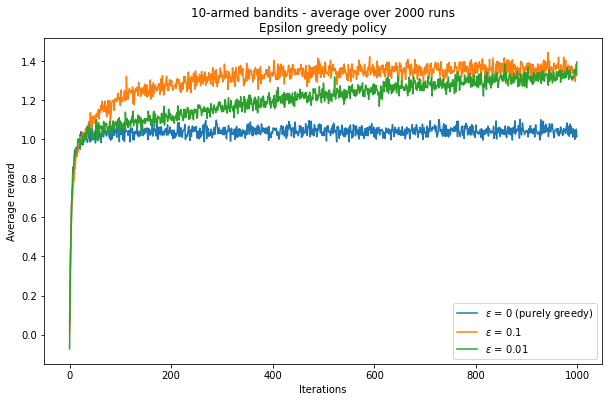

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(rewards_0_avg, label=r'$\epsilon$ = 0 (purely greedy)')
plt.plot(rewards_01_avg, label=r'$\epsilon$ = 0.1')
plt.plot(rewards_001_avg, label=r'$\epsilon$ = 0.01')
plt.title("10-armed bandits - average over 2000 runs\nEpsilon greedy policy")
plt.xlabel("Iterations")
plt.ylabel("Average reward")
plt.legend()

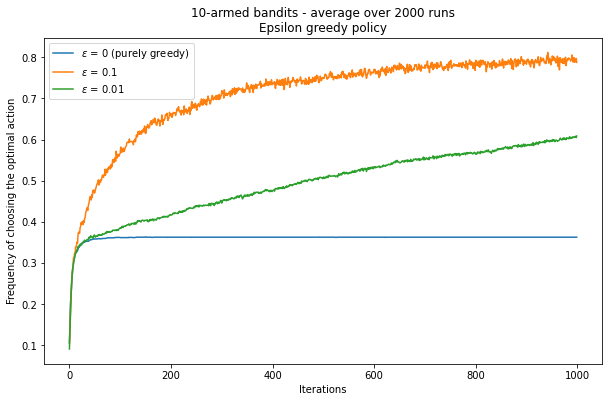

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(freq_optimal_actions_0, label=r'$\epsilon$ = 0 (purely greedy)')
plt.plot(freq_optimal_actions_01, label=r'$\epsilon$ = 0.1')
plt.plot(freq_optimal_actions_001, label=r'$\epsilon$ = 0.01')
plt.title("10-armed bandits - average over 2000 runs\nEpsilon greedy policy")
plt.xlabel("Iterations")
plt.ylabel("Frequency of choosing the optimal action")
plt.legend()

## Optimistic initialization

In [ ]:
rewards_init_5_eps_0, freq_optimal_actions_init_5_eps_0 = simulation(n_machines=n_machines, n_tokens=n_tokens, n_runs=n_runs, epsilon=0, init=5, algorithm='epsilon_greedy', alpha=0.1)
rewards_init_5_eps_0_avg = rewards_init_5_eps_0 / n_runs

100%|██████████| 2000/2000 [00:24<00:00, 81.50it/s]


In [ ]:
rewards_init_0_eps_01, freq_optimal_actions_init_0_eps_01 = simulation(n_machines, n_tokens, n_runs, epsilon=0.1, init=0, algorithm='epsilon_greedy', alpha=0.1)
rewards_init_0_eps_01_avg = rewards_init_0_eps_01 / n_runs

100%|██████████| 2000/2000 [00:24<00:00, 80.77it/s]


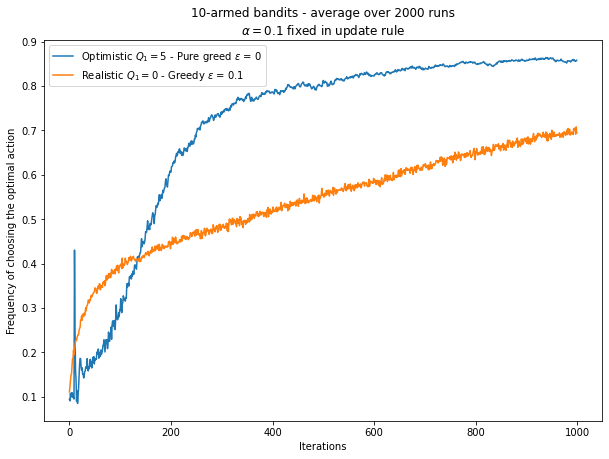

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(freq_optimal_actions_init_5_eps_0, label=r'Optimistic $Q_1=5$ - Pure greed $\epsilon$ = 0')
plt.plot(freq_optimal_actions_init_0_eps_01, label=r'Realistic $Q_1=0$ - Greedy $\epsilon$ = 0.1')
plt.title("10-armed bandits - average over 2000 runs\n" + r"$\alpha=0.1$ fixed in update rule")
plt.xlabel("Iterations")
plt.ylabel("Frequency of choosing the optimal action")
plt.legend()

## UCB

In [ ]:
rewards_ucb, freq_optimal_actions_ucb = simulation(n_machines, n_tokens, n_runs, algorithm='ucb', alpha=0.1)
rewards_ucb_avg = rewards_ucb / n_runs

  0%|          | 0/2000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
100%|██████████| 2000/2000 [00:37<00:00, 52.77it/s]


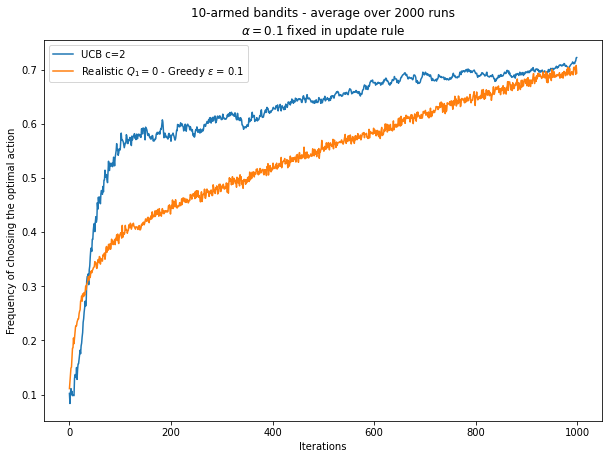

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(freq_optimal_actions_ucb, label=r'UCB c=2')
plt.plot(freq_optimal_actions_init_0_eps_01, label=r'Realistic $Q_1=0$ - Greedy $\epsilon$ = 0.1')
plt.title("10-armed bandits - average over 2000 runs\n" + r"$\alpha=0.1$ fixed in update rule")
plt.xlabel("Iterations")
plt.ylabel("Frequency of choosing the optimal action")
plt.legend()

In [ ]:
# Variable
n_iter = 1000 # iterations
k = 10 # number of machines
esperance_vector = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) # Q* for each machine
number_machine = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
preferance_vector = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]) # Initial weight for each machine
learning_rate = 0.5 # alpha

# Functions


def reward(machine_x):
    result = np.random.normal(machine_x, 1) # give the result from the machine i
    return result

In [ ]:
def GradientBandit(bandits, iterations, step_size, no_baseline=False):
    k = len(bandits)
    H = np.zeros(k)
    P = np.ones(k) / k
    N = np.zeros(k)

    is_optimal = np.zeros(iterations)
    avg_reward = 0
    for t in range(1, iterations + 1): 
        A = np.random.choice(number_machine, p=preference_vector)
        R = reward(esperance_vector[A])
        avg_reward = avg_reward + (1.0 / t) * (R - avg_reward)
        baseline = 0.0 if no_baseline else avg_reward

        H[A] = H[A] + step_size * (R - baseline) * (1 - P[A])
        for a in range(k):
            if a != A:
                H[a] = H[a] - step_size * (R - baseline) * P[a]


        aux_exp = np.exp(H)
        P = aux_exp / np.sum(aux_exp)
        is_optimal[t - 1] = int(bandits.is_optimal(A)) * 1.0


    return P, is_optimal